In [1]:
import numpy as np    
import uproot3
import matplotlib.pyplot as plt

In [2]:
infile = '/Users/yw18581/Downloads/largedrum_1L_dense_MedianCut_3cmVoxel_withoutCut.discriminator.root'

In [118]:
fu = uproot3.open(infile)
histogram = fu['histMedianMetric'].numpy()[0]
bins_x, bins_y, bins_z = fu['histMedianMetric;1'].numpy()[1][0]

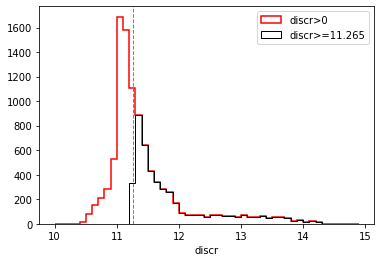

In [119]:
mybins = np.arange(10,15,.1)
plt.hist(histogram.ravel(), bins = mybins,edgecolor='red', linewidth=1.5,histtype=u'step', label='discr>0')
plt.hist(histogram[histogram>=11.265], bins=mybins,  edgecolor='k', histtype=u'step',label='discr>=11.265')
plt.axvline(x=11.265, linestyle='--', c='gray', linewidth=1)
plt.legend(loc='upper right')
plt.xlabel('discr')
plt.show()

In [267]:
#define cube, to get coordinates of neighbours for each voxel
def cube(x, y, z):
    if x in [0,65] or y in [0, 65] or z in [0,32]:
        return None
    mgrid = np.mgrid[x-1:x+2:2, y-1:y+2:2, z-1:z+2:2]
    x, y, z = map(np.ravel, mgrid)
    return x, y, z

In [268]:
thresh=11.265
stats_air_air = dict()
xx, yy, zz = np.where(histogram>=thresh)
for x, y, z in zip(xx, yy, zz):
    cubes_coord = cube(x, y, z)
    if cubes_coord is None:
        continue
    xs, ys, zs = cubes_coord
    #xs, ys, zs = map(np.ravel, cubes_coord)
    triplets = np.array([(i, j, k) for (i, j, k) in zip(xs, ys, zs)])
    #cx, cy, cz = cubes_coord
    cube_around_pt = np.array([histogram[cx, cy, cz] for (cx, cy, cz) in triplets])
    filtered_cube = cube_around_pt[cube_around_pt >= thresh]
    over_threshold_count = (len(filtered_cube) -1) if (len(filtered_cube) > 0) else 0.
    stats_air_air[(x, y, z)] = over_threshold_count

In [269]:
min(stats_air_air.values()), max(stats_air_air.values())

(0, 7)

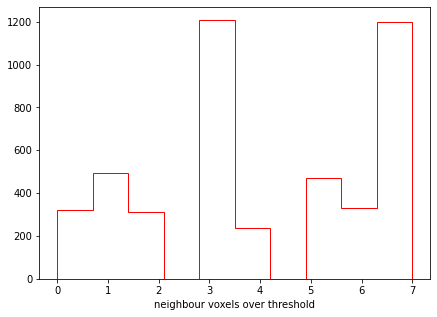

In [282]:
plt.figure(figsize=(7,5))
bb =np.arange(-.5, 27.5, 1)
plt.hist(stats_air_air.values(), bins = 10, edgecolor='red', histtype=u'step', density=False)
plt.xlabel('neighbour voxels over threshold')
#plt.xticks(np.arange(-0.5,27.5,3))
plt.show()

In [271]:
stats_ct_ct = dict()
xx, yy, zz = np.where(np.logical_and(histogram>0, histogram<thresh))
for x, y, z in zip(xx, yy, zz):
    cubes_coord = cube(x, y, z)
    xs, ys, zs = map(np.ravel, cubes_coord)
    triplets = np.array([(x, y, z) for (x, y, z) in zip(xs, ys, zs)])
    if cubes_coord is None:
        continue
    #cx, cy, cz = cubes_coord
    filtered_cube = np.array([histogram[cx, cy, cz] for (cx, cy, cz) in triplets])
    filtered_cube = filtered_cube[filtered_cube < thresh]
    over_threshold_count = (len(filtered_cube)-1) if (len(filtered_cube) > 0) else 0
    #for i, (pt, val) in enumerate(zip(triplets, filtered_cube)): 
    #    print(i, pt, val)
    #break
    stats_ct_ct[(x, y, z)] = over_threshold_count

In [272]:
min(stats_ct_ct.values()), max(stats_ct_ct.values())

(0, 7)

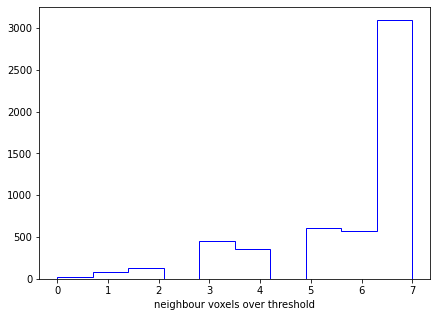

In [281]:
plt.figure(figsize=(7,5))
#bb =np.arange(-.5, 27.5, 1)
plt.hist(stats_ct_ct.values(), bins = 10, edgecolor='blue', histtype=u'step', density=False)
plt.xlabel('neighbour voxels over threshold')
#plt.xticks(np.arange(-0.5,27.5,3))
plt.show()

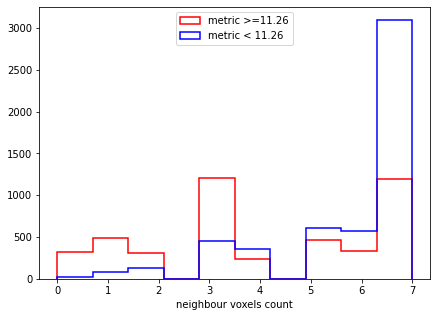

In [280]:
plt.figure(figsize=(7,5))
#bb =np.arange(-0.5, 27.5, 1)
plot_kwds = {'density': False, 'linewidth':"1.5", 'histtype': u'step', "bins":10}
plt.hist(stats_air_air.values(), label='metric >=11.26', edgecolor='red', **plot_kwds)
plt.hist(stats_ct_ct.values(), label='metric < 11.26', edgecolor='blue', **plot_kwds)
plt.xlabel('neighbour voxels count')
#plt.xticks(np.arange(-0.5,27.5,3))
plt.legend(loc='upper center')
#plt.yscale('log')
plt.show()

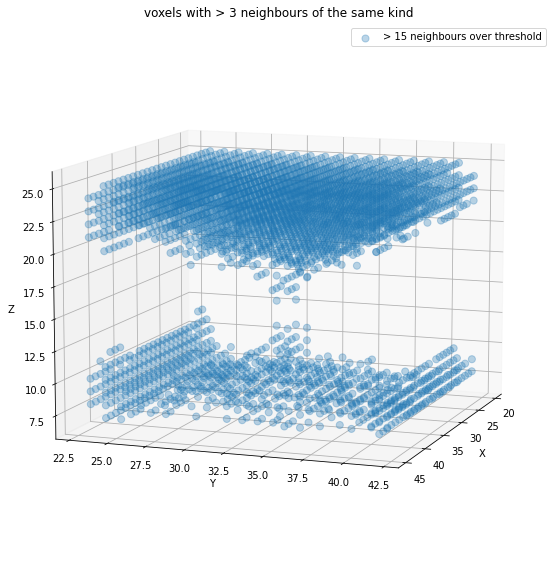

In [279]:
interesting = list(filter(lambda e: stats_air_air[e] >= 3, stats_air_air))
interesting_out = list(filter(lambda e: stats_ct_ct[e] >= 3, stats_ct_ct))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection="3d")
ax.set_title('voxels with > 3 neighbours of the same kind')
#ax.scatter(np.array(interesting_out)[:,0],np.array(interesting_out)[:,1],np.array(interesting_out)[:,2], 
#           s=20, alpha=.3, label='> 15 neighbours under threshold')
ax.scatter(np.array(interesting)[:,0],np.array(interesting)[:,1],np.array(interesting)[:,2], 
           s=50, alpha=.3, label='> 15 neighbours over threshold')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend(loc='upper right')
ax.view_init(elev=10, azim=20)
plt.draw()


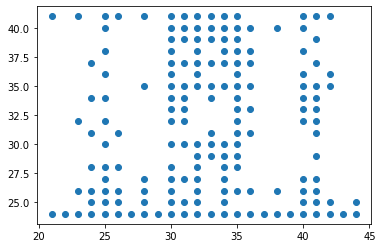

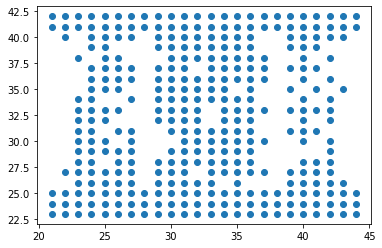

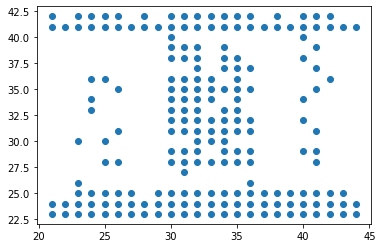

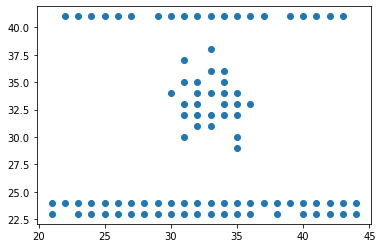

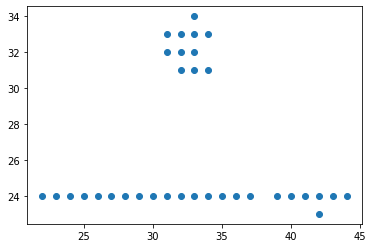

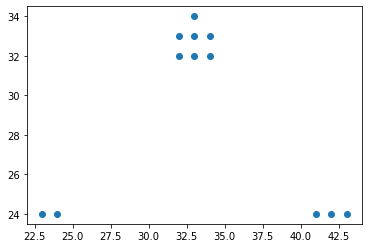

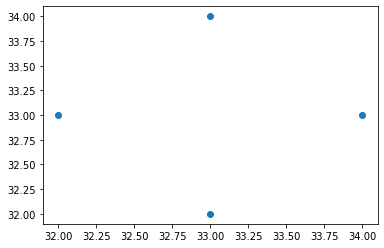

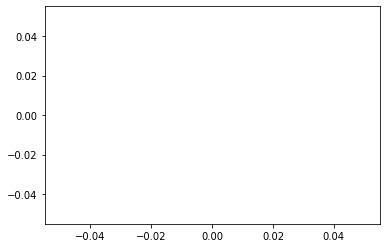

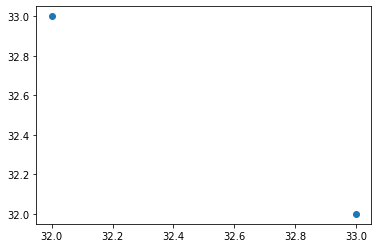

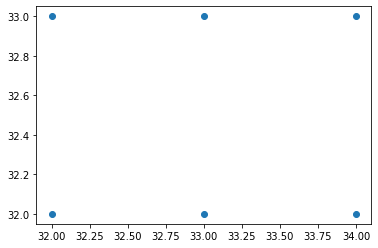

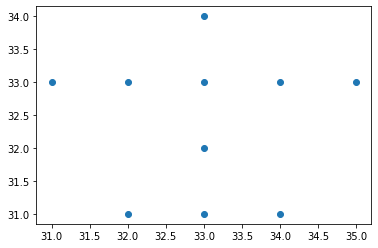

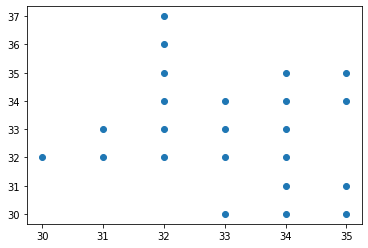

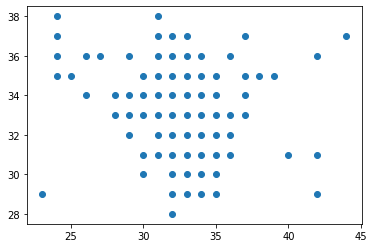

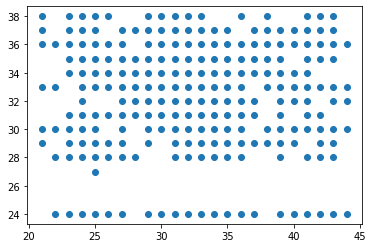

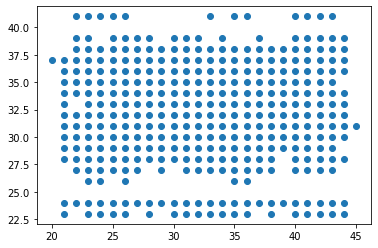

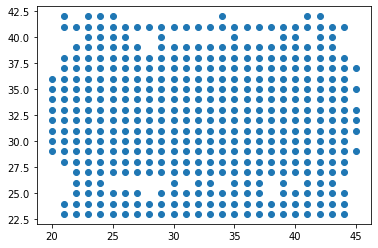

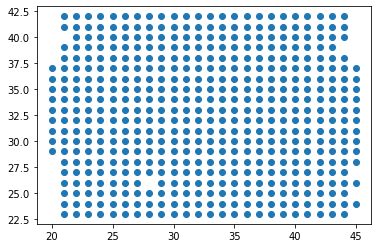

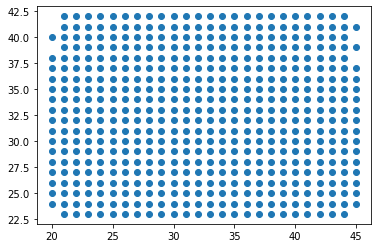

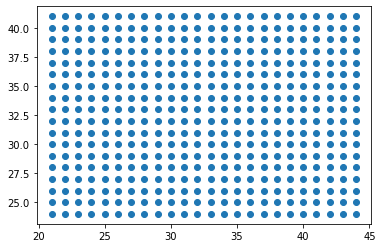

In [277]:
for j in range(7,26):
    ixx = []
    iyy = []
    for ix, iy, iz in interesting:
        if iz!=j:
            continue
        ixx.append(ix)
        iyy.append(iy)
    ixx = np.asarray(ixx)
    iyy = np.asarray(iyy)
    plt.scatter(ixx, iyy)
    plt.show()

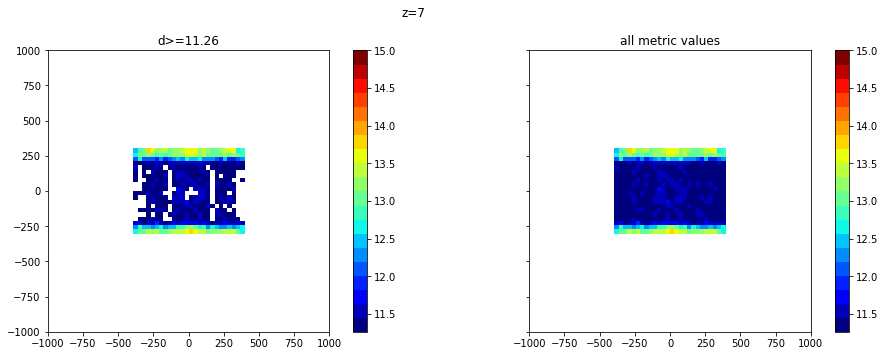

In [240]:
from matplotlib import cm, colors
cmap = cm.get_cmap('jet', 20)
norm = colors.Normalize(vmin=11.265, vmax=15)
cmap.set_bad(color='white')

air_histogram = np.copy(histogram)
air_histogram[air_histogram<11.265]=0
masked_hist_air = np.ma.masked_where(air_histogram == 0, air_histogram)
masked_hist = np.ma.masked_where(histogram == 0, histogram)

for i in range(7, 26):#filtered_hist.shape[2]):
    fig, ax = plt.subplots(1,2, figsize= (14,5),sharex=True, sharey=True)
    fig.suptitle('z={}'.format(i))
    im1 = ax[0].imshow(np.swapaxes(masked_hist_air, 0,1)[:,:,i], cmap=cmap, norm=norm, extent=[-1000,1000,-1000,1000])#, origin='lower')
    im2 = ax[1].imshow(np.swapaxes(masked_hist,0,1)[:,:,i], cmap=cmap, norm=norm, extent=[-1000,1000,-1000,1000])
    
    ax[0].set_title('d>=11.26')
    ax[1].set_title('all metric values')
    fig.colorbar(im1, ax=ax[0], shrink=1)
    fig.colorbar(im2, ax=ax[1], shrink=1)
    plt.tight_layout()
    plt.show()
    break

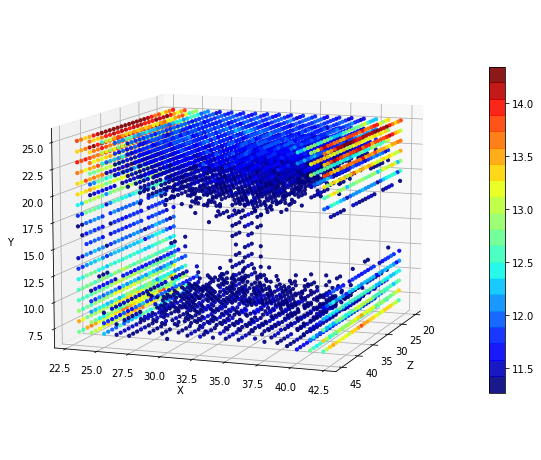

In [266]:
 
cmap = plt.cm.get_cmap('jet',20)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection="3d")
#ax.set_title('voxels with > 15 neighbours of the same kind')
xx, yy, zz = np.where(histogram >= 11.265)
pnt3d = ax.scatter(xx, yy, zz, c=histogram[histogram>=11.265], cmap=cmap, s=10, alpha=.9)
cbar=plt.colorbar(pnt3d, shrink=0.6)
ax.set_xlabel('Z')
ax.set_ylabel('X')
ax.set_zlabel('Y')
# plt.legend(loc='upper right')
ax.view_init(elev=10, azim=20)
plt.draw()